In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.constrained_layout.use'] = True

import dask
print(f'dask: {dask.__version__}')

import toolbox_scs as tb
print(tb.__file__)
import toolbox_scs.routines.boz as boz

dask: 2.11.0
/home/lleguy/notebooks/ToolBox/src/toolbox_scs/__init__.py


# Improved method

The delay is scan and saved in the DAQ while recording a single run.

In [2]:
proposal = 900257
dNB = 67
rNB = 68

In [3]:
arr_dark, tid_dark = boz.load_dssc_module(proposal, dNB, drop_intra_darks=False)

In [4]:
arr_dark

dask.array<reshape, shape=(758, 82, 128, 512), dtype=uint16, chunksize=(128, 82, 128, 512), chunktype=numpy.ndarray>

In [5]:
dark = arr_dark.mean(axis=0).compute()

In [6]:
arr, tid = boz.load_dssc_module(proposal, rNB, drop_intra_darks=False)
arr = arr - dark

In [7]:
fields = ["DSSC_delay"]

run, data = tb.load(proposal, rNB, fields)

Bunch pattern table not found in run. Skipping!


In [8]:
data

<xarray.Dataset>
Dimensions:     (trainId: 3987)
Coordinates:
  * trainId     (trainId) uint64 1356431136 1356431137 ... 1356435121 1356435122
Data variables:
    DSSC_delay  (trainId) int32 4756934 4756934 4756934 ... 4756963 4756963
Attributes:
    runFolder:  /gpfs/exfel/exp/SCS/202230/p900257/raw/r0068

In [9]:
intensity = (arr[:,::2,:,:] - arr[:,1::2,:,:]).mean(axis=(1,2,3)).compute()

In [10]:
import xarray as xr

In [11]:
xrintensity = xr.DataArray(intensity, coords={'trainId':tid}, dims=['trainId']).to_dataset(name='intensity')

In [12]:
xrintensity

<xarray.Dataset>
Dimensions:    (trainId: 3987)
Coordinates:
  * trainId    (trainId) uint64 1356431136 1356431137 ... 1356435121 1356435122
Data variables:
    intensity  (trainId) float64 -0.05101 -0.05173 -0.04971 ... 0.1101 0.09043

In [13]:
r = xr.merge([data, xrintensity], join='inner', combine_attrs='no_conflicts')

In [14]:
rbin = r.groupby('DSSC_delay').mean()

Text(0, 0.5, 'Intensity')

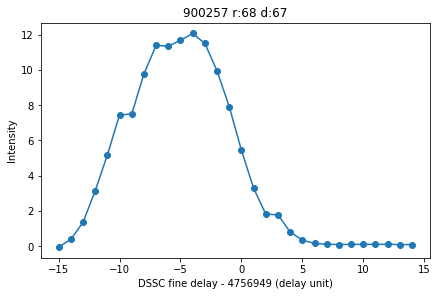

In [15]:
offset = 4756949
plt.figure()
plt.plot(rbin['DSSC_delay'] - offset, rbin['intensity'], marker='o')
plt.title(f'{proposal} r:{rNB} d:{dNB}')
plt.xlabel(f'DSSC fine delay - {offset} (delay unit)')
plt.ylabel('Intensity')

# Legacy

One run is recorded for one fine delay in sequence, the delay itself is not saved in the data

In [16]:
runs = np.arange(775, 814+1)
delay = np.arange(4756930, 4756969+1)

In [17]:
proposal = 2937

use first run as dark

In [18]:
arr_dark, tid_dark = boz.load_dssc_module(proposal, runs[0])
dark = boz.average_module(arr_dark).compute()

In [19]:
intensity = np.zeros((len(runs)))
for k,r in enumerate(runs):
    arr, tid = boz.load_dssc_module(proposal, r)
    data = boz.average_module(arr, dark=dark).compute()
    sensor = data[:,:,:256]
    intensity[k] = sensor.mean(axis=(0,1,2))

Text(0, 0.5, '<intensity>')

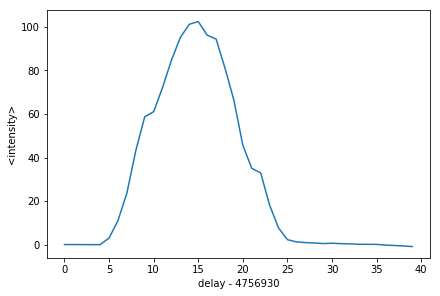

In [20]:
plt.figure()
plt.plot(delay-delay[0], intensity)
plt.xlabel(f'delay - {delay[0]}')
plt.ylabel('<intensity>')